In [1]:
import warnings;
warnings.simplefilter('ignore')

In [2]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
import orca
import os; os.chdir('/home/juan/ual_model_workspace/spring-2019-models')#('../')
from statsmodels.discrete.discrete_model import MNLogit
import pandas as pd
import numpy as np

from collections import OrderedDict
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import GradientBoostingClassifier

from urbansim_templates.models import SmallMultinomialLogitStep
import seaborn as sns

# from scripts import datasources
# from scripts import variables
# # from scripts import utils
# from scripts import models
from scripts import datasources, models, variables

from matplotlib import pyplot as plt
%matplotlib inline

/home/juan/anaconda3/envs/template-env/lib/python3.6/site-packages/pandana/network.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/juan/anaconda3/envs/template-env/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/juan/anaconda3/envs/template-env/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/juan/anaconda3/envs/template-env/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/juan/anaconda3/envs/template-env/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/juan/anaconda

Registering model step 'auto_ownership'
Registering model step 'TOD_choice'
Registering model step 'primary_mode_choice'
Registering model step 'WLCM'


In [3]:
orca.run(['initialize_network_small', 'network_aggregations_small'])

orca.run(['initialize_network_walk', 'network_aggregations_walk'])

print()

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'network_aggregations_small'
Computing accessibility variables
Computing units_10000
Computing units_sf_10000
Computing units_mf_10000
Computing pop_10000
Computing hh_10000
Computing poor_10000
Computing renters_10000
Computing avg_income_10000
Computing jobs_10000
Computing avg_rent_10000
Computing med_rent_10000
Computing pop_white_10000
Computing pop_black_10000
Computing pop_asian_10000
Computing pop_hisp_10000
Computing units_25000
Computing units_sf_25000
Computing units_mf_25000
Computing pop_25000
Computing hh_25000
Computing poor_25000
Computing renters_25000
Computing avg_income_25000
Computing jobs_25000
Computing avg_rent_25000
Computing pop_white_25000
Computing pop_black_25000
Computing pop_asian_25000
Computing pop_hisp_25000
Computing jobs_10000_retail
Computing jobs_25000_retail
Computing jobs_10000_fire
Computing jobs_25000_fire
Computing jobs_10000_tech
Compu

## Getting skim-based accessibility variables

In [4]:
walk_net_vars = pd.read_csv('/home/data/spring_2019/base/walk_net_vars.csv', index_col='osmid')
drive_net_vars = pd.read_csv('/home/data/spring_2019/base/drive_net_vars.csv', index_col='osmid')
# zones = pd.read_csv('./data/zones_w_access_vars-base.csv', index_col='zone_id', dtype={'zone_id': int})
orca.add_table('nodeswalk', walk_net_vars)
orca.add_table('nodessmall', drive_net_vars)
# orca.add_table('zones', zones)


In [5]:
os.getcwd()

'/home/juan/ual_model_workspace/spring-2019-models'

In [6]:
skim_based_accessibilities = pd.read_csv('/home/data/spring_2019/base/zones_w_access_vars.csv')

In [7]:
skim_based_accessibilities.columns

Index(['zone_id', 'gid', 'area', 'acres', 'total_jobs',
       'sum_residential_units', 'sum_persons', 'sum_income', 'avg_income',
       'total_jobs_gen_tt_CAR_15', 'total_jobs_gen_tt_CAR_45',
       'sum_persons_gen_tt_CAR_15', 'sum_persons_gen_tt_CAR_45',
       'sum_income_gen_tt_CAR_15', 'sum_income_gen_tt_CAR_45',
       'sum_residential_units_gen_tt_CAR_15',
       'sum_residential_units_gen_tt_CAR_45', 'avg_income_gen_tt_CAR_30',
       'total_jobs_gen_tt_WALK_TRANSIT_15',
       'total_jobs_gen_tt_WALK_TRANSIT_45',
       'sum_persons_gen_tt_WALK_TRANSIT_15',
       'sum_persons_gen_tt_WALK_TRANSIT_45',
       'sum_income_gen_tt_WALK_TRANSIT_15',
       'sum_income_gen_tt_WALK_TRANSIT_45',
       'sum_residential_units_gen_tt_WALK_TRANSIT_15',
       'sum_residential_units_gen_tt_WALK_TRANSIT_45',
       'total_jobs_gen_tt_RIDE_HAIL_15', 'total_jobs_gen_tt_RIDE_HAIL_45',
       'sum_persons_gen_tt_RIDE_HAIL_15', 'sum_persons_gen_tt_RIDE_HAIL_45',
       'sum_income_gen_tt_RIDE

In [8]:
#Loading am peak transit accessibility varaibles
@orca.table(cache=False)
def am_acc():
    df = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
    df.block_id = df.block_id.str.zfill(15)
    return df

households = orca.get_table('households').to_frame()
# persons = orca.get_table('persons').to_frame()
persons = pd.read_csv('/home/data/spring_2019/2025/persons.csv', 
                      index_col='member_id', dtype={'member_id': int, 'household_id': int})

parcels = orca.get_table('parcels').to_frame()
nodessmall = orca.get_table('nodessmall').to_frame()
# nodessmall = pd.read_csv('/home/data/2018-07/nodessmall_vars.csv')
nodessmall.index.name = 'node_id_small'
nodeswalk = orca.get_table('nodeswalk').to_frame()
# nodeswalk = pd.read_csv('/home/data/2018-07/nodeswalk_vars.csv')
nodeswalk.index.name = 'node_id_walk'
am_acc = orca.get_table('am_acc').to_frame()

In [9]:
persons = pd.read_csv('/home/data/spring_2019/2025/persons.csv',) 
#                       index_col='member_id', dtype={'member_id': int, 'household_id': int})
persons.head()

,Unnamed: 0,student,household_id,age,primary_commute_mode,worker,work_at_home,sex,hours,hispanic,race_id,member_id,edu,relate,earning
0,0,0,0,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
1,1,0,670,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
2,2,0,740,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
3,3,0,975,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
4,4,0,977,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0


In [10]:
#Creating a Parcel Table with accessibility variables 

# Merging transit accessibility to parcels (Have to do this manually because orca.merge_tables performs inner merge only)
parcels_acc = parcels.reset_index().merge(am_acc, how='left', on='block_id').set_index('parcel_id')

#Filling transit accessibility NA with median value and adding columns to the parcelDataFrame in orca
for acc_col in set(parcels_acc.columns) - set(parcels):
    parcels_acc[acc_col].fillna(parcels_acc[acc_col].median())

parcels_acc = parcels_acc.reset_index().merge(nodessmall, 
                                          how='left', 
                                          left_on='node_id_small',
                                          right_index= True).set_index('parcel_id')

parcels_acc = parcels_acc.reset_index().merge(nodeswalk, 
                                          how='left', 
                                          left_on='node_id_walk',
                                          right_index= True).set_index('parcel_id')

## Merging

In [11]:
persons_chts = pd.read_csv('/home/data/fall_2018/chts_persons_w_zone_ids.csv')
household_chts = pd.read_csv("/home/data/fall_2018/CHTS_csv_format/data/Deliv_HH.csv")

In [12]:
# Variables in the persons table
# persons_chts['worker'] = [1 if x == 1 else 0 for x in persons_chts['EMPLY']]
persons_chts['children'] = [1 if x < 18 else 0 for x in persons_chts.AGE]
persons_chts['TransitPass'] = persons_chts.TRANS.apply(lambda x: 1 if x == 1 else 0)

#Age categories 
persons_chts['age_0_15'] = [1 if x < 16 else 0 for x in persons_chts.AGE]
persons_chts['age_16_17'] = [1 if (x >= 16) & (x <=17) else 0 for x in persons_chts.AGE]
persons_chts['age_18_25'] = [1 if (x >= 18) & (x <=23) else 0 for x in persons_chts.AGE]
persons_chts['age_25_40'] = [1 if (x >= 24) & (x <=38) else 0 for x in persons_chts.AGE]
persons_chts['age_40_60'] = [1 if (x >= 39) & (x <=60) else 0 for x in persons_chts.AGE]
persons_chts['age_60'] = [1 if x > 60 else 0 for x in persons_chts.AGE]

#Occupation Categories 
persons_chts['worker_student'] = [1 if (persons_chts.EMPLY[x] == 1) & (persons_chts.STUDE[x] <=2) else 0 for x in range(len(persons_chts.EMPLY))]
persons_chts['non_worker_non_student'] = [1 if (persons_chts.EMPLY[x] != 1) & (persons_chts.STUDE[x] > 2) else 0 for x in range(len(persons_chts.EMPLY))]
persons_chts['worker'] = [1 if (persons_chts.EMPLY[x] == 1) & (persons_chts.worker_student[x] != 1) else 0 for x in range(len(persons_chts.EMPLY))]
persons_chts['student'] = [1 if (persons_chts.STUDE[x] <= 2) & (persons_chts.worker_student[x] != 1) else 0 for x in range(len(persons_chts.EMPLY))]


# #Creating person-based variables to merge onto Household table
person_var = persons_chts.groupby(by ='SAMPN').agg({'PERNO': 'count',
                                                    'AGE': 'max',
                                                    'zone_id_home': 'first',
                                                    'EMPLY':'sum', 
                                                    'children':'sum',
                                                    'TransitPass':'sum',
                                                    'parcel_id_home': 'first',
                                                    'age_0_15': 'sum',
                                                    'age_16_17': 'sum',
                                                    'age_18_25': 'sum',
                                                    'age_25_40': 'sum',
                                                    'age_40_60': 'sum',
                                                    'age_60': 'sum', 
                                                    'non_worker_non_student': 'sum',
                                                    'worker_student':'sum',
                                                    'worker': 'sum',
                                                    'student': 'sum'})

household_chts = household_chts.merge(person_var, how = 'left', left_on = 'SAMPN', right_index=True )
household_chts = household_chts.dropna(subset=['PERNO', 'AGE', 'zone_id_home', 'children'])
household_chts['max_35'] = [1 if x <=35 else 0 for x in household_chts.AGE]

#Creating a Parcel Table with accessibility variables 
# Merging transit accessibility to parcels (Have to do this manually because orca.merge_tables performs inner merge only)
parcels_acc = parcels.reset_index().merge(am_acc, how='left', on='block_id').set_index('parcel_id')

#Filling transit accessibility NA 
for acc_col in set(parcels_acc.columns) - set(parcels):
    parcels_acc[acc_col].fillna(parcels_acc[acc_col].median())

parcels_acc = parcels_acc.reset_index().merge(nodessmall, 
                                          how='left', 
                                          left_on='node_id_small',
                                          right_index= True).set_index('parcel_id')

parcels_acc = parcels_acc.reset_index().merge(nodeswalk, 
                                          how='left', 
                                          left_on='node_id_walk',
                                          right_index= True).set_index('parcel_id')


#Merging parcels accesibilities onto household
df_merge = household_chts.merge(parcels_acc, how = 'left', left_on ='parcel_id_home', right_index= True )

#Merging skim_based accesibilities onto households
df_merge = df_merge.merge(skim_based_accessibilities, how = 'left', left_on = 'zone_id_home', right_on = 'zone_id' )

df_merge = df_merge[df_merge.INCOM<50]

In [13]:
df_merge

,SAMPN,RECMODE,RETMODE,INCEN,ILANG,CTFIP,AREA,STRATA,STYPE,CEC,...,sum_residential_units_gen_tt_WALK_TRANSIT_15,sum_residential_units_gen_tt_WALK_TRANSIT_45,total_jobs_gen_tt_RIDE_HAIL_15,total_jobs_gen_tt_RIDE_HAIL_45,sum_persons_gen_tt_RIDE_HAIL_15,sum_persons_gen_tt_RIDE_HAIL_45,sum_income_gen_tt_RIDE_HAIL_15,sum_income_gen_tt_RIDE_HAIL_45,sum_residential_units_gen_tt_RIDE_HAIL_15,sum_residential_units_gen_tt_RIDE_HAIL_45
0,1031985,1,3,1,1,6095,22,10,1,NaN,...,6636.0,52547.0,3630.0,12548.0,19614.0,46422.0,6.987224e+08,1.634723e+09,6636.0,16945.0
1,1033944,1,3,2,1,6075,22,11,1,NaN,...,75642.0,424040.0,18909.0,154870.0,147809.0,768073.0,5.117425e+09,3.602344e+10,53623.0,330884.0
3,1037952,1,1,1,2,6081,22,12,1,NaN,...,14226.0,146273.0,8137.0,124571.0,40330.0,202070.0,1.321637e+09,1.167025e+10,12964.0,86760.0
4,1039620,1,3,2,1,6085,22,13,1,NaN,...,41783.0,228975.0,18724.0,167091.0,45251.0,327509.0,3.283840e+09,2.064467e+10,19061.0,146747.0
5,1041076,1,3,2,1,6081,22,12,1,NaN,...,27984.0,134460.0,10369.0,113400.0,60104.0,208717.0,3.276593e+09,1.263931e+10,25216.0,91700.0
6,1041304,1,3,2,1,6085,22,13,1,NaN,...,48122.0,300876.0,31267.0,164981.0,95112.0,530311.0,4.378381e+09,2.374111e+10,39826.0,217613.0
7,1041494,1,1,1,1,6013,22,6,1,NaN,...,15186.0,108745.0,16283.0,76123.0,32677.0,132170.0,1.236680e+09,4.795369e+09,13108.0,56855.0
8,1041766,1,3,2,1,6081,22,12,1,NaN,...,21422.0,169406.0,6216.0,99146.0,51405.0,239296.0,2.457927e+09,1.095710e+10,20502.0,96532.0
9,1043613,1,3,1,1,6001,22,5,1,NaN,...,78675.0,285897.0,63231.0,196733.0,85096.0,421939.0,4.078643e+09,1.888223e+10,47846.0,212483.0
10,1044414,1,2,1,1,6013,22,6,1,NaN,...,19149.0,72753.0,4914.0,30131.0,38323.0,226804.0,1.337701e+09,7.231837e+09,13198.0,79246.0


In [14]:
df_merge['cars_alt'] = df_merge['HHVEH'].apply(lambda x: 0*(x==0)+ 1*(x==1)+ 2*(x==2)+3*(x>=3))
df_merge['RESTY'] = [1 if (x>=4) & (x<=6) else 0 for x in df_merge.RESTY]
df_merge['single_family'] = [1 if x >= 1 else 0 for x in df_merge.HHSIZ]

In [15]:
#Getting variables names for each data source
accessibility_var = set(parcels_acc) - set(parcels)
parcel_var = set(parcels.columns) - set(accessibility_var)
skim_accessibility = set(skim_based_accessibilities.columns)
households_var_continious = ['INCOM','AGE', 'children']#, 'TransitPass'] # ,'PERNO', 'EMPLY'                   
households_var_dummy = ['max_35', 'age_0_15', 
                    'age_16_17', 'age_18_25', 'age_25_40','age_40_60',
                    'age_60', 'worker_student', 'non_worker_non_student',
                   'worker','student','RESTY', 'TEN']#, 'HHLIC', ]
dependent_var = ['cars_alt']

In [16]:
final_var = list(accessibility_var) + households_var_continious + households_var_dummy + dependent_var +list(skim_accessibility)

#Creating a dataset with varaibles needed
df = df_merge.loc[:,final_var]

In [17]:
df.head()

,jobs_25000_fire,renters_25000,above_jobs_60,pop_white_1500_walk,children_500_walk,jobs_500_walk_finance,hh_500_walk,pop_hisp_2500_walk,elderly_hh_1500_walk,sqft_unit_1500_walk,...,avg_income,sum_income_gen_tt_RIDE_HAIL_45,total_jobs_gen_tt_CAR_45,sum_persons_gen_tt_RIDE_HAIL_15,gid,sum_residential_units_gen_tt_WALK_TRANSIT_45,zone_id,area,sum_residential_units_gen_tt_WALK_TRANSIT_15,sum_residential_units
0,5090.0,38606.0,50494.445312,15240.0,3078.0,23.0,5604.0,10519.0,1949.0,2022.866094,...,116144.015625,1.634723e+09,121940.0,19614.0,1247,52547.0,NaN,5.400809e+07,6636.0,3318.0
1,57503.0,274310.0,509891.406250,7624.0,674.0,5.0,1132.0,8814.0,1869.0,1221.707094,...,97540.829038,3.602344e+10,518591.0,147809.0,694,424040.0,NaN,1.100155e+06,75642.0,3205.0
3,42381.0,171391.0,452086.906250,5298.0,652.0,1.0,566.0,15452.0,415.0,1538.478577,...,104089.334737,1.167025e+10,568902.0,40330.0,866,146273.0,NaN,3.330501e+06,14226.0,2657.0
4,40101.0,183007.0,403929.375000,5648.0,161.0,80.0,217.0,3706.0,509.0,1831.591279,...,232740.538071,2.064467e+10,573497.0,45251.0,1136,228975.0,NaN,2.689819e+06,41783.0,1559.0
5,32647.0,112875.0,403581.281250,5770.0,165.0,0.0,257.0,3741.0,651.0,1811.429783,...,152752.436222,1.263931e+10,366658.0,60104.0,859,134460.0,NaN,1.115332e+06,27984.0,1096.0


## Machine learning approach

In [18]:
def normalize(data):
    ''' 
    Normalizes values in a Series
    Input: 
    data: Series-like
    
    Return: Normalized Series-like object
    '''
    if data.dtype == 'O':
        return 0
    else:
        return (data - np.mean(data)) / np.std(data)

In [19]:
df_ml = df_merge.loc[:,final_var]

to_normalize =  households_var_continious + list(accessibility_var) 

for i in to_normalize:
    df_ml[i] = normalize(df_ml[i])

df_ml = df_ml.dropna(axis=1)

#Splitting the data
x = df_ml.drop(['cars_alt'], axis = 1)
y = df_ml.loc[:,'cars_alt']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)

In [20]:
model = GradientBoostingClassifier(max_depth=3, n_estimators=100)
model.fit(X_train, y_train)
importances = model.feature_importances_
pd.crosstab( y_test, model.predict(X_test))
model.score(X_test, y_test)

0.636112071947423

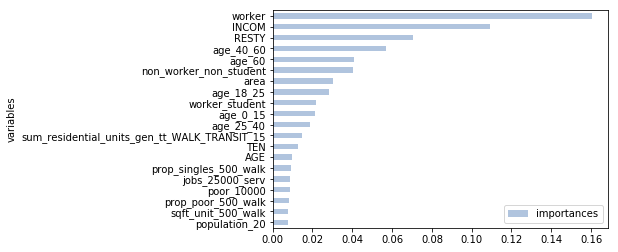

In [21]:
bb = pd.DataFrame({'importances':model.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= True)

bb[-20:].plot.barh(x = 'variables', y='importances', color ='lightsteelblue')#, figsize =(15,5) )
plt.yticks();#(fontsize = 10)

In [22]:
pd.crosstab( y_test, model.predict(X_test))

col_0,0,1,2,3
cars_alt,,,,
0,67,112,14,0
1,35,573,243,9
2,9,192,1003,70
3,3,40,325,196


In [23]:
model.score(X_test, y_test)

0.636112071947423

## Estimation

In [24]:
df_mnl = df[list(bb[bb.importances>bb.importances.mean()].variables)]
df_mnl['cars_alt'] = df['cars_alt']

In [25]:
continous_var = ['jobs_10000_serv', 'sqft_unit_500_walk', 'prop_singles_1500_walk',
                 'avg_hhs_1500_walk', 'jobs_25000', 'prop_poor_500_walk','jobs_10000_tech', 
                 'population_20', 'jobs_25000_tech', 'poor_10000']

dumy_var = ['TransitPass', 'age_0_15','worker_student', 'age_18_25', 'non_worker_non_student', 
            'age_60', 'age_40_60', 'RESTY', 'INCOM', 'worker']

dependet_variable = ['cars_alt']

In [26]:
#Creates 3 dummies for income
#df_mnl['income_0_50k'] = [1 if x<=4 else 0 for x in df_mnl.INCOM]
df_mnl['income_50K_150k'] = [1 if (x>4) & (x<=7) else 0 for x in df_mnl.INCOM]
df_mnl['income_+150K'] = [1 if x>=8 else 0 for x in df_mnl.INCOM]
df_mnl.drop(['INCOM'], axis = 1, inplace = True)

#Creating an intercept
df_mnl['intercept'] = np.ones(df_mnl.shape[0])

In [27]:
x = df_mnl.drop(['cars_alt'], axis = 1)
y = df_mnl.loc[:,'cars_alt']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)

In [28]:
@orca.injectable(autocall=False)
def COM(y, x):
    model = MNLogit(y_train, X_train)
    result = model.fit()
    return result

In [29]:
COM_model = orca.get_injectable('COM')(y_train, X_train)

COM_model.summary().add_table_params

Optimization terminated successfully.
         Current function value: 0.841417
         Iterations 10


<bound method Summary.add_table_params of <class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
Dep. Variable:               cars_alt   No. Observations:                 5867
Model:                        MNLogit   Df Residuals:                     5774
Method:                           MLE   Df Model:                           90
Date:                Wed, 10 Jul 2019   Pseudo R-squ.:                  0.3074
Time:                        08:45:06   Log-Likelihood:                -4936.6
converged:                       True   LL-Null:                       -7127.1
                                        LLR p-value:                     0.000
                                  cars_alt=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
jobs_25000_finance                           -3.988e

# Validation 

In [30]:
#Prediction
mnl_result = COM_model.predict(X_train)
mnl_result['predicted'] = mnl_result.idxmax(axis=1, skipna=True)

#Cross tab
pd.crosstab( y_train, mnl_result['predicted'], normalize= 'index').round(decimals=3)

predicted,0,1,2,3
cars_alt,,,,
0,0.301,0.602,0.089,0.007
1,0.032,0.682,0.274,0.012
2,0.003,0.135,0.807,0.055
3,0.002,0.051,0.584,0.363


In [31]:
a = pd.crosstab( y_train, mnl_result['predicted'])
accuracy = np.sum(np.diagonal(np.array(a)))/y_train.shape[0]
accuracy

0.6545082665757628